In [16]:
MODELS_FROM_FILE = 0
IMPORTANCES_FROM_FILE = 0

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import ElasticNet

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score, r2_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)


data_intermediate_dir = "data/intermediate/"
item_lvl_w_imp = pd.read_csv(data_intermediate_dir + "item_lvl_w_impairment.csv")

# Prepare input and ouptut column names

output_cols = [x for x in item_lvl_w_imp.columns if x.startswith("WIAT") or x.startswith("WISC")] # All WISC and WIAT columns

input_cols = [x for x in item_lvl_w_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")] # Input columns are all columns except Diagnosis, WIAT, and WISC

# Separate test set for all output columns

# Shuffle the dataset 
shuffle_df = item_lvl_w_imp.sample(frac=1, random_state=42)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_w_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

In [17]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeRegressor()
    rf = RandomForestRegressor()
    svr = svm.SVR()
    en = ElasticNet()
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svr_pipe = make_pipeline(imputer, scaler, svr)
    en_pipe = make_pipeline(imputer, scaler, en)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeregressor__splitter": ["best","random"],
        "decisiontreeregressor__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeregressor__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeregressor__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeregressor__max_leaf_nodes": np.random.randint(2, 50, 30)
    }
    rf_param_grid = {
        'randomforestregressor__max_depth' : np.random.randint(5, 150, 30),
        'randomforestregressor__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestregressor__n_estimators': np.random.randint(50, 400, 10),
        'randomforestregressor__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestregressor__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0]
    }
    svr_param_grid = {
        'svr__C': loguniform(1e-03, 1e+02),
        'svr__gamma': loguniform(1e-03, 1e+02),
        'svr__degree': uniform(2, 5),
        'svr__epsilon': loguniform(1e-03,1),
        'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    en_param_grid = {
        'elasticnet__alpha': loguniform(1e-5, 100),
        'elasticnet__l1_ratio': uniform(0, 1)
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svr_pipe, svr_param_grid),
        (en_pipe, en_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col):
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=3, scoring="r2", n_iter=100, n_jobs = -1)
    
    rs.fit(train_set[input_cols], train_set[output_col]) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    return (best_estimator, best_score)

In [18]:
def find_best_estimator_for_output(output_col):
    best_score = 0
    best_classifier = None
    base_models_and_param_grids = get_base_models_and_param_grids()
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, output_col)
        if best_score_for_model > best_score:
            best_classifier = best_classifier_for_model
            best_score = best_score_for_model
    return best_classifier

In [19]:
if MODELS_FROM_FILE == 0:
    best_estimators = {}
    for output in output_cols:
        best_estimator_for_output = find_best_estimator_for_output(output)
        best_estimators[output] = best_estimator_for_output
        print("Best estimator for ", output, ": ", best_estimators[output])

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.908e+03, tolerance: 2.555e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.943e+02, tolerance: 2.672e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.215e+03, tolerance: 2.960e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.936e+02, tolerance: 2.555e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e+02, tolerance: 2.960e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e+03, tolerance: 2.672e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.226e+03, tolerance: 2.960e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.355e+03, tolerance: 2.555e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.634e+02, tolerance: 2.960e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.203e+01, tolerance: 2.672e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.180e+03, tolerance: 2.555e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.674e+03, tolerance: 2.672e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.656e+03, tolerance: 2.960e+01
  model = cd_fast.enet_coordinate_descent(


Best estimator for  WIAT,WIAT_Num_Stnd :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=60, max_features=0.5,
                                       min_samples_leaf=10,
                                       min_samples_split=18,
                                       n_estimators=174))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e+02, tolerance: 2.552e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.377e+02, tolerance: 2.480e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.614e+03, tolerance: 2.552e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.582e+03, tolerance: 2.480e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.168e+01, tolerance: 2.411e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.519e+03, tolerance: 2.552e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.158e+03, tolerance: 2.552e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.587e+03, tolerance: 2.480e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.645e+03, tolerance: 2.552e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.603e+03, tolerance: 2.480e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.768e+03, tolerance: 2.480e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.195e+03, tolerance: 2.411e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.670e+03, tolerance: 2.552e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.511e+03, tolerance: 2.552e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  WIAT,WIAT_Word_Stnd :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.7800601293107295,
                            l1_ratio=0.3821674152400245))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.271e+02, tolerance: 8.916e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e+02, tolerance: 8.630e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e+02, tolerance: 8.916e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.099e+02, tolerance: 8.767e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e+02, tolerance: 8.630e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.333e+02, tolerance: 8.916e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.507e+02, tolerance: 8.916e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e+02, tolerance: 8.767e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e+02, tolerance: 8.916e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.506e+02, tolerance: 8.630e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  WISC,WISC_Coding_Scaled :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.15628443333177106,
                            l1_ratio=0.9669003659599646))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.602e+03, tolerance: 2.266e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.872e+03, tolerance: 2.282e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e+03, tolerance: 2.282e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.553e+03, tolerance: 2.316e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.419e+02, tolerance: 2.266e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.720e+02, tolerance: 2.282e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.034e+03, tolerance: 2.266e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.255e+03, tolerance: 2.282e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e+02, tolerance: 2.266e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.042e+02, tolerance: 2.282e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e+03, tolerance: 2.266e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.276e+03, tolerance: 2.282e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  WISC,WISC_FSIQ :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.48314894066911696,
                            l1_ratio=0.824840489557851))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e+00, tolerance: 8.082e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e+00, tolerance: 8.082e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.551e+01, tolerance: 8.335e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e+02, tolerance: 8.455e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e+02, tolerance: 8.082e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.066e+02, tolerance: 8.335e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.406e+02, tolerance: 8.082e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e+02, tolerance: 8.082e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e+02, tolerance: 8.082e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.073e+02, tolerance: 8.335e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.348e+01, tolerance: 8.455e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e+02, tolerance: 8.082e-01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  WISC,WISC_SS_Scaled :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=87, max_features=1.0,
                                       min_samples_leaf=11, min_samples_split=7,
                                       n_estimators=89))])


In [20]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best estimators - best parameters, and the estimator objects themselves
    best_estimators_df = pd.DataFrame([best_estimators]).T.reset_index()
    best_estimators_df.columns = ["Output", "Best Estimator"]
    display(best_estimators_df)
    best_estimators_df.to_csv("data/output/best-estimators-cog-scores-item-lvl.csv")

    dump(best_estimators, 'best-estimators-cog-scores-item-lvl.joblib', compress=1)

Output  \
0       WIAT,WIAT_Num_Stnd   
1      WIAT,WIAT_Word_Stnd   
2  WISC,WISC_Coding_Scaled   
3           WISC,WISC_FSIQ   
4      WISC,WISC_SS_Scaled   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [21]:
if MODELS_FROM_FILE == 1:
    best_estimators = load('best-estimators-cog-scores-item-lvl.joblib')

In [22]:
metric_names = ['r2']   
def get_metrics(estimator, output_col, input_cols, validation_or_test = "validation", print_output_flag = 0):
    input_cols = input_cols
    
    if validation_or_test == "test":
        x = test_set[input_cols]
        y = test_set[output_col]
    else: 
        x = val_set[input_cols]
        y = val_set[output_col]
        
    y_pred = estimator.predict(x)
    
    metrics = []
    r2 = r2_score(y, y_pred)
    metrics.append(r2)
    
    if print_output_flag:
        print(output_col)
        print("r2: ", r2)
        
        plt.scatter(y, y_pred)
        plt.show()
        
    return metrics

,test_score,train_score
0,0.180565,0.590681
1,0.178389,0.584316
2,0.227376,0.582920
3,0.148768,0.597234
4,0.209618,0.579082


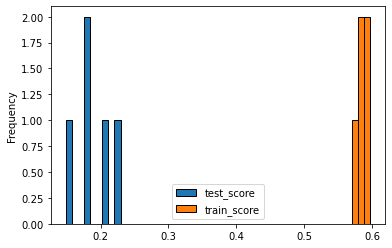

,test_score,train_score
0,0.280659,0.478078
1,0.224793,0.491283
2,0.310849,0.466615
3,0.234934,0.486056
4,0.268557,0.466908


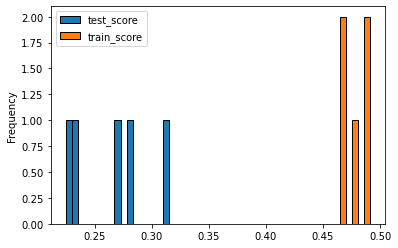

,test_score,train_score
0,0.113139,0.260791
1,0.163314,0.233544
2,0.175414,0.245115
3,0.167484,0.243551
4,0.123828,0.252637


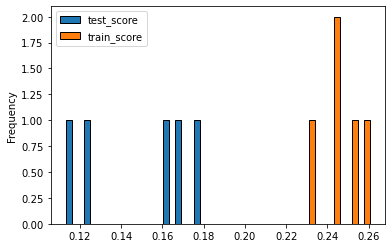

,test_score,train_score
0,0.390933,0.570014
1,0.404787,0.569471
2,0.417231,0.560146
3,0.391952,0.565277
4,0.379190,0.560680


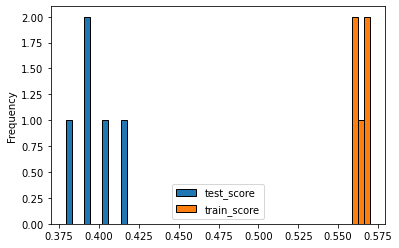

,test_score,train_score
0,0.081633,0.553806
1,0.104125,0.545569
2,0.118566,0.545267
3,0.062208,0.553441
4,0.107074,0.543730


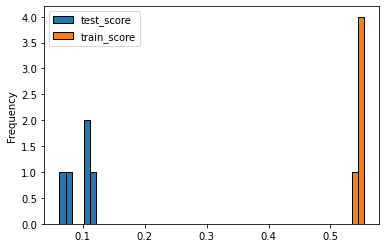

,Output,Mean R2,Std R2
0,"WIAT,WIAT_Num_Stnd",0.188943,0.027204
1,"WIAT,WIAT_Word_Stnd",0.263958,0.031225
2,"WISC,WISC_Coding_Scaled",0.148636,0.025152
3,"WISC,WISC_FSIQ",0.396819,0.013033
4,"WISC,WISC_SS_Scaled",0.094721,0.020189


In [23]:
# Check cross-validation performance of the final model on validation set for all models
def plot_test_vs_train_scores(cv_results):
    scores = pd.DataFrame(cv_results)[["test_score", "train_score"]]
    display(scores)
    scores.plot.hist(bins=50, edgecolor="black")
    plt.show()

results_val_set = []
for output in output_cols:
    estimator = best_estimators[output]
    cv_results = cross_validate(estimator, train_set[input_cols], train_set[output], return_train_score = True)
    metrics = [np.mean(cv_results["test_score"]), np.std(cv_results["test_score"])]
    results_val_set.append([
        output, 
        *metrics])
    
    plot_test_vs_train_scores(cv_results)
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Output"] + ["Mean R2", "Std R2"])
restults_val_set_df

WIAT,WIAT_Num_Stnd
r2:  0.19134081004357906


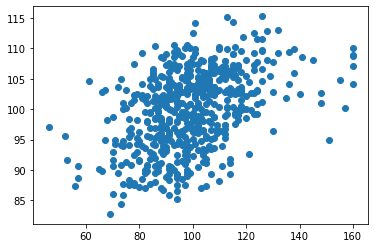

WIAT,WIAT_Word_Stnd
r2:  0.2993897471524053


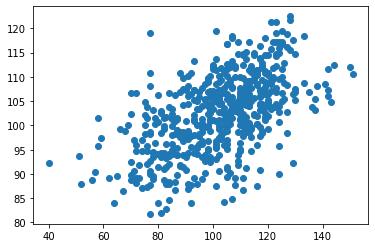

WISC,WISC_Coding_Scaled
r2:  0.15709130975504004


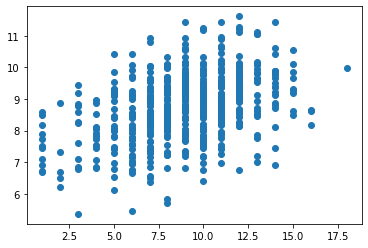

WISC,WISC_FSIQ
r2:  0.4446497684142876


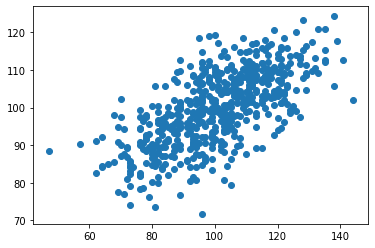

WISC,WISC_SS_Scaled
r2:  0.12033058693495657


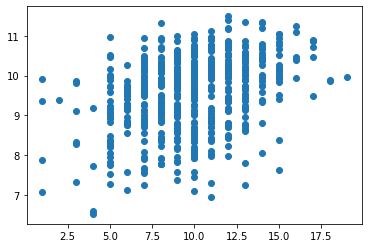

,Output,r2
3,"WISC,WISC_FSIQ",0.444650
1,"WIAT,WIAT_Word_Stnd",0.299390
0,"WIAT,WIAT_Num_Stnd",0.191341
2,"WISC,WISC_Coding_Scaled",0.157091
4,"WISC,WISC_SS_Scaled",0.120331


In [24]:
# Check performance of the final model on test set for all models

results_test_set = []
for output in output_cols:
    estimator = best_estimators[output]
    metrics = get_metrics(estimator, output, input_cols, 'test', 1)
    results_test_set.append([
        output, 
        *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Output"] + metric_names)
restults_test_set_df.sort_values(by="r2", ascending=False)

### Feature importance

In [25]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["r2"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["r2"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

WIAT,WIAT_Num_Stnd


,r2
1,0.097093
2,0.118478
3,0.135942
4,0.171360
5,0.193017
...,...
96,0.237478
97,0.238330
98,0.238556
99,0.239195


Max score:  0.24361043348107425  at  46  features


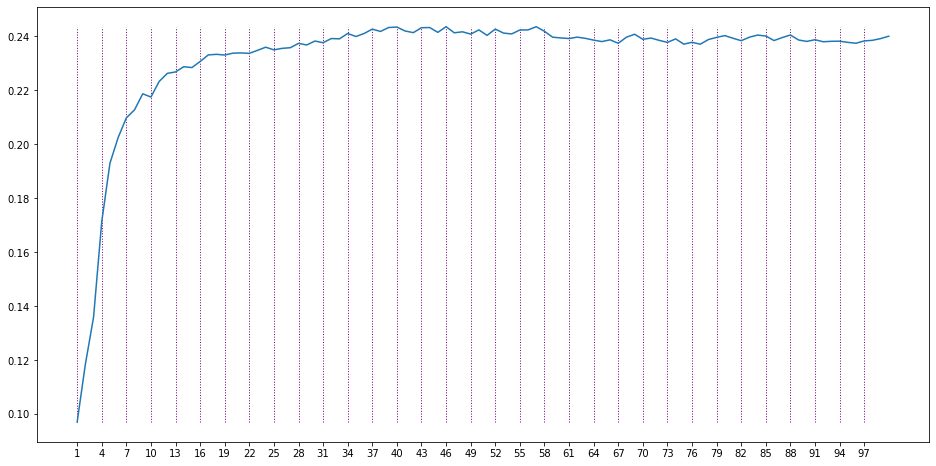

Optimal number of features:  12


('Basic_Demos,Age',
 'SCQ,SCQ_05',
 'ASSQ,ASSQ_02',
 'SWAN,SWAN_06',
 'SRS,SRS_43',
 'CBCL,CBCL_61',
 'CBCL,CBCL_83',
 'ICU_P,ICU_P_20',
 'APQ_P,APQ_P_31',
 'PSI,PSI_14',
 'PSI,PSI_18',
 'APQ_SR,APQ_SR_07A_WAS_MISSING')

WIAT,WIAT_Word_Stnd


,r2
1,0.126396
2,0.152093
3,0.173225
4,0.187148
5,0.200570
...,...
96,0.363553
97,0.363808
98,0.364050
99,0.364272


Max score:  0.36449283525090176  at  100  features


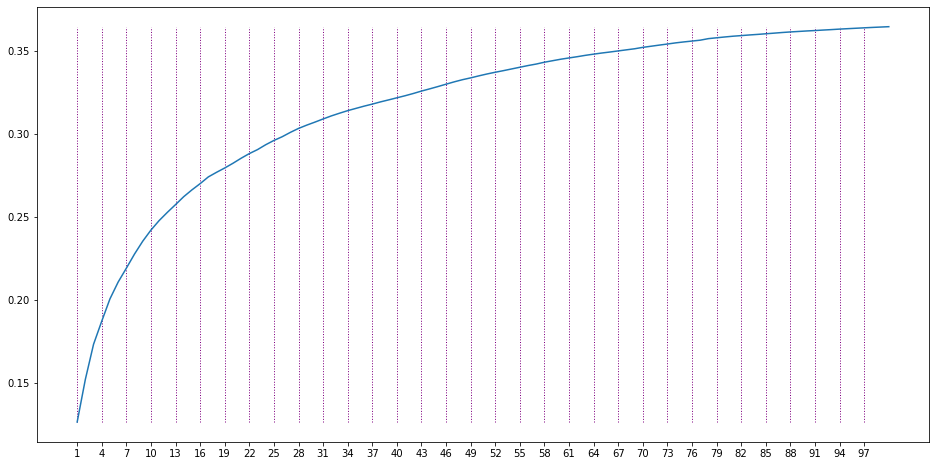

Optimal number of features:  27


('SympChck,CSC_36C',
 'SympChck,CSC_46P',
 'SCQ,SCQ_05',
 'SCQ,SCQ_14',
 'ASSQ,ASSQ_05',
 'SDQ,SDQ_20',
 'SDQ,SDQ_27',
 'SDQ,SDQ_29_c',
 'SWAN,SWAN_06',
 'SRS,SRS_09',
 'SRS,SRS_14',
 'CBCL,CBCL_04',
 'CBCL,CBCL_17',
 'CBCL,CBCL_58',
 'CBCL,CBCL_61',
 'CBCL,CBCL_79',
 'APQ_P,APQ_P_34',
 'APQ_P,APQ_P_37',
 'DTS,DTS_06',
 'MFQ_P,MFQ_P_01',
 'APQ_SR,APQ_SR_16',
 'APQ_SR,APQ_SR_38',
 'PSI,PSI_01',
 'PSI,PSI_18',
 'RBS,RBS_09',
 'CIS_SR,CIS_SR_08',
 'APQ_SR,APQ_SR_15A_WAS_MISSING')

WISC,WISC_Coding_Scaled


,r2
1,0.056349
2,0.082354
3,0.106561
4,0.130794
5,0.140609
...,...
96,0.188421
97,0.188421
98,0.188421
99,0.188421


Max score:  0.18842179327074915  at  64  features


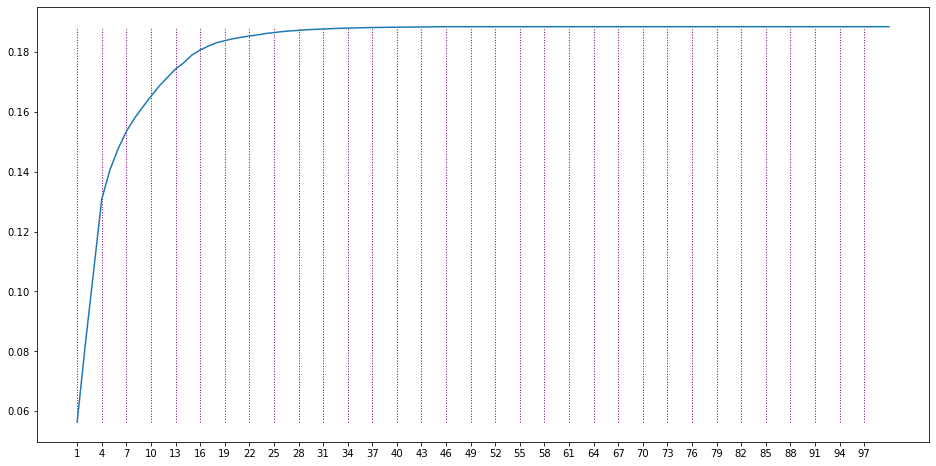

Optimal number of features:  17


('Basic_Demos,Age',
 'Basic_Demos,Sex',
 'SympChck,CSC_06P',
 'ASSQ,ASSQ_01',
 'SDQ,SDQ_20',
 'SWAN,SWAN_06',
 'SRS,SRS_21',
 'SRS,SRS_49',
 'CBCL,CBCL_01',
 'CBCL,CBCL_18',
 'CBCL,CBCL_62',
 'CBCL,CBCL_80',
 'ICU_P,ICU_P_06',
 'APQ_P,APQ_P_35',
 'APQ_P,APQ_P_40',
 'APQ_SR,APQ_SR_39',
 'PSI,PSI_18')

WISC,WISC_FSIQ


,r2
1,0.192420
2,0.228383
3,0.254970
4,0.279349
5,0.299521
...,...
96,0.473444
97,0.473494
98,0.473546
99,0.473598


Max score:  0.4736383310965497  at  100  features


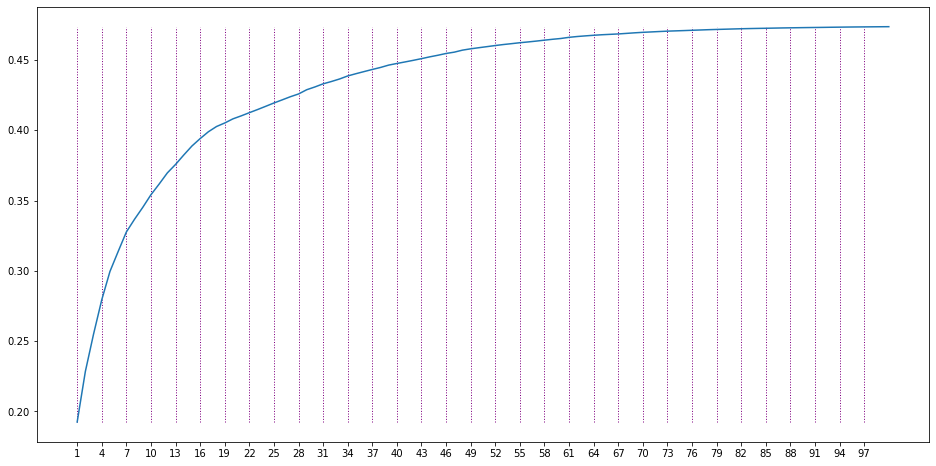

Optimal number of features:  18


('Basic_Demos,Age',
 'SCQ,SCQ_05',
 'SCQ,SCQ_39',
 'Barratt,financialsupport',
 'SDQ,SDQ_20',
 'SWAN,SWAN_06',
 'SRS,SRS_43',
 'CBCL,CBCL_17',
 'APQ_P,APQ_P_18',
 'APQ_P,APQ_P_31',
 'APQ_P,APQ_P_37',
 'ESWAN,MDD_5',
 'APQ_SR,APQ_SR_05',
 'APQ_SR,APQ_SR_38',
 'PSI,PSI_02',
 'PSI,PSI_08',
 'PSI,PSI_18',
 'RBS,RBS_36')

WISC,WISC_SS_Scaled


,r2
1,0.053645
2,0.067750
3,0.079969
4,0.091022
5,0.106628
...,...
96,0.149738
97,0.152605
98,0.154892
99,0.155849


Max score:  0.15584931744894162  at  99  features


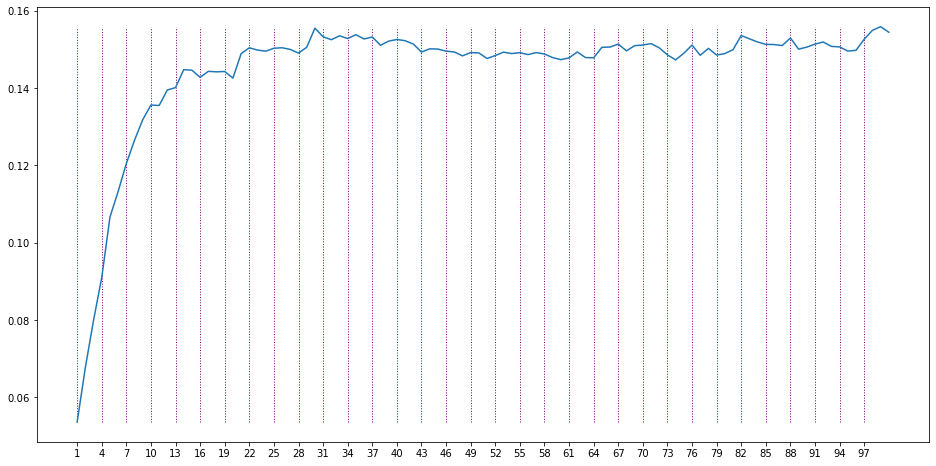

Optimal number of features:  14


('SympChck,CSC_18P',
 'SympChck,CSC_43C',
 'SCQ,SCQ_03',
 'ASSQ,ASSQ_04',
 'ASSQ,ASSQ_11',
 'CBCL,CBCL_03',
 'CBCL,CBCL_32',
 'ICU_P,ICU_P_02',
 'ICU_P,ICU_P_09',
 'APQ_P,APQ_P_31',
 'ESWAN,Panic_B02',
 'PSI,PSI_05',
 'PSI,PSI_18',
 'RBS,RBS_40')

In [26]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for output in output_cols:
        print(output)
        estimator = best_estimators[output]

        sfs = SequentialFeatureSelector(estimator, 
              k_features=100,
              forward=True, 
              scoring='r2',
              cv=3,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[output])

        forward_feature_subsets[output] = sfs.subsets_
        forward_feature_objects[output] = sfs
        
        analyze_importances(forward_feature_objects[output].subsets_)

In [27]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward-sfs-cog-scores-item-lvl.joblib', compress=1)

WIAT,WIAT_Num_Stnd


,r2
1,0.097093
2,0.118478
3,0.135942
4,0.171360
5,0.193017
...,...
96,0.237478
97,0.238330
98,0.238556
99,0.239195


Max score:  0.24361043348107425  at  46  features


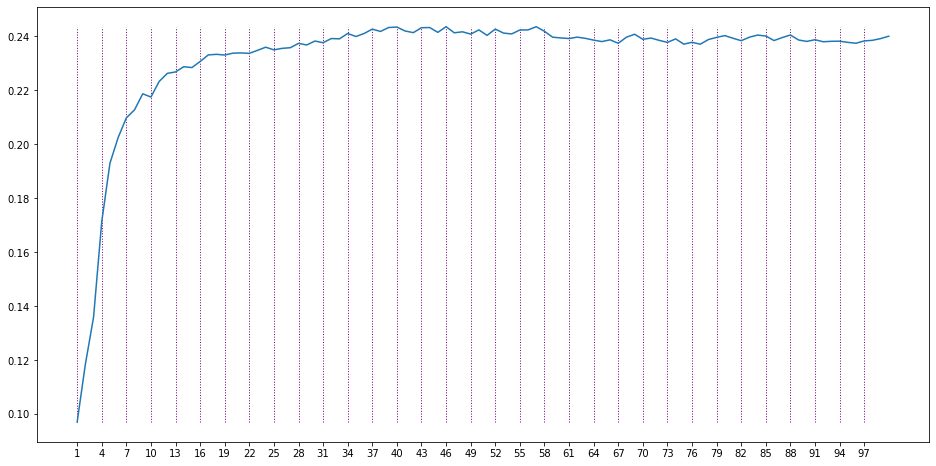

Optimal number of features:  12


('Basic_Demos,Age',
 'SCQ,SCQ_05',
 'ASSQ,ASSQ_02',
 'SWAN,SWAN_06',
 'SRS,SRS_43',
 'CBCL,CBCL_61',
 'CBCL,CBCL_83',
 'ICU_P,ICU_P_20',
 'APQ_P,APQ_P_31',
 'PSI,PSI_14',
 'PSI,PSI_18',
 'APQ_SR,APQ_SR_07A_WAS_MISSING')

Score using all features: 
WIAT,WIAT_Num_Stnd
r2:  0.19283114205585772


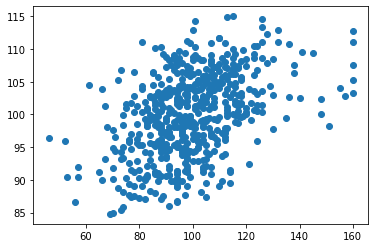

R2:  0.19283114205585772
Performance on test set using optimal number of columns: 
WIAT,WIAT_Num_Stnd
r2:  0.16434276974815976


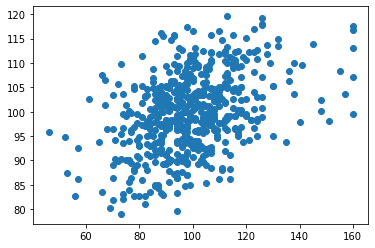

R2:  0.16434276974815976
Performance on test set using number of columns with maximum score
WIAT,WIAT_Num_Stnd
r2:  0.17672557275764889


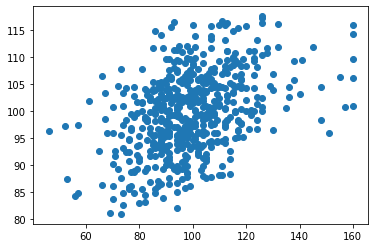

R2:  0.17672557275764889
WIAT,WIAT_Word_Stnd


,r2
1,0.126396
2,0.152093
3,0.173225
4,0.187148
5,0.200570
...,...
96,0.363553
97,0.363808
98,0.364050
99,0.364272


Max score:  0.36449283525090176  at  100  features


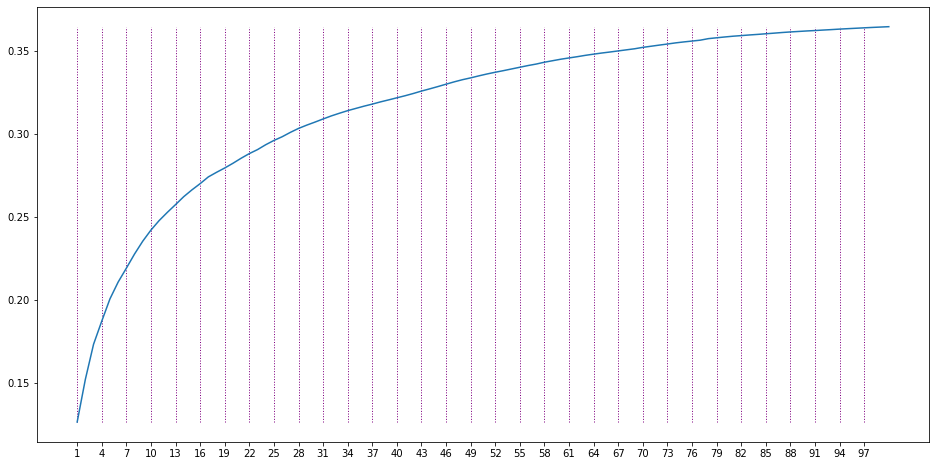

Optimal number of features:  27


('SympChck,CSC_36C',
 'SympChck,CSC_46P',
 'SCQ,SCQ_05',
 'SCQ,SCQ_14',
 'ASSQ,ASSQ_05',
 'SDQ,SDQ_20',
 'SDQ,SDQ_27',
 'SDQ,SDQ_29_c',
 'SWAN,SWAN_06',
 'SRS,SRS_09',
 'SRS,SRS_14',
 'CBCL,CBCL_04',
 'CBCL,CBCL_17',
 'CBCL,CBCL_58',
 'CBCL,CBCL_61',
 'CBCL,CBCL_79',
 'APQ_P,APQ_P_34',
 'APQ_P,APQ_P_37',
 'DTS,DTS_06',
 'MFQ_P,MFQ_P_01',
 'APQ_SR,APQ_SR_16',
 'APQ_SR,APQ_SR_38',
 'PSI,PSI_01',
 'PSI,PSI_18',
 'RBS,RBS_09',
 'CIS_SR,CIS_SR_08',
 'APQ_SR,APQ_SR_15A_WAS_MISSING')

Score using all features: 
WIAT,WIAT_Word_Stnd
r2:  0.2993897471524053


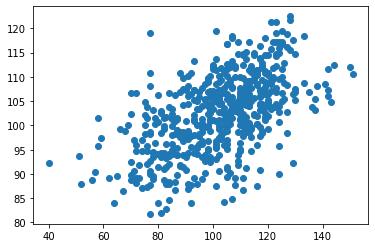

R2:  0.2993897471524053
Performance on test set using optimal number of columns: 
WIAT,WIAT_Word_Stnd
r2:  0.24978986531831315


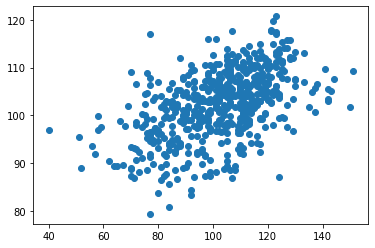

R2:  0.24978986531831315
Performance on test set using number of columns with maximum score
WIAT,WIAT_Word_Stnd
r2:  0.29969285907177123


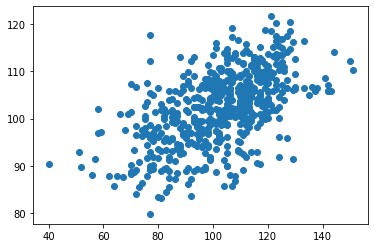

R2:  0.29969285907177123
WISC,WISC_Coding_Scaled


,r2
1,0.056349
2,0.082354
3,0.106561
4,0.130794
5,0.140609
...,...
96,0.188421
97,0.188421
98,0.188421
99,0.188421


Max score:  0.18842179327074915  at  64  features


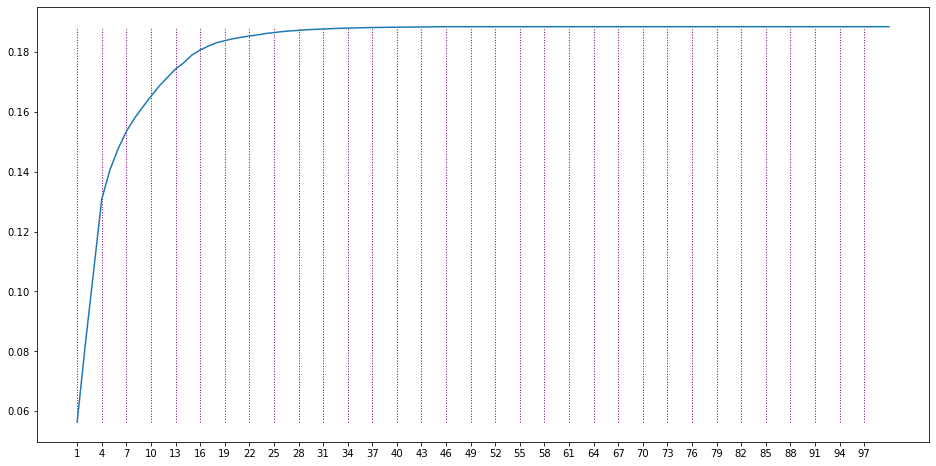

Optimal number of features:  17


('Basic_Demos,Age',
 'Basic_Demos,Sex',
 'SympChck,CSC_06P',
 'ASSQ,ASSQ_01',
 'SDQ,SDQ_20',
 'SWAN,SWAN_06',
 'SRS,SRS_21',
 'SRS,SRS_49',
 'CBCL,CBCL_01',
 'CBCL,CBCL_18',
 'CBCL,CBCL_62',
 'CBCL,CBCL_80',
 'ICU_P,ICU_P_06',
 'APQ_P,APQ_P_35',
 'APQ_P,APQ_P_40',
 'APQ_SR,APQ_SR_39',
 'PSI,PSI_18')

Score using all features: 
WISC,WISC_Coding_Scaled
r2:  0.15709130975504004


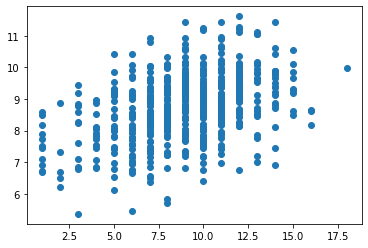

R2:  0.15709130975504004
Performance on test set using optimal number of columns: 
WISC,WISC_Coding_Scaled
r2:  0.13766736855304218


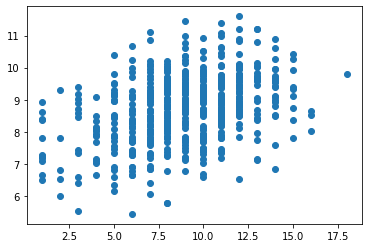

R2:  0.13766736855304218
Performance on test set using number of columns with maximum score
WISC,WISC_Coding_Scaled
r2:  0.14661357225535276


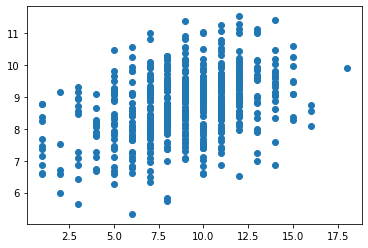

R2:  0.14661357225535276
WISC,WISC_FSIQ


,r2
1,0.192420
2,0.228383
3,0.254970
4,0.279349
5,0.299521
...,...
96,0.473444
97,0.473494
98,0.473546
99,0.473598


Max score:  0.4736383310965497  at  100  features


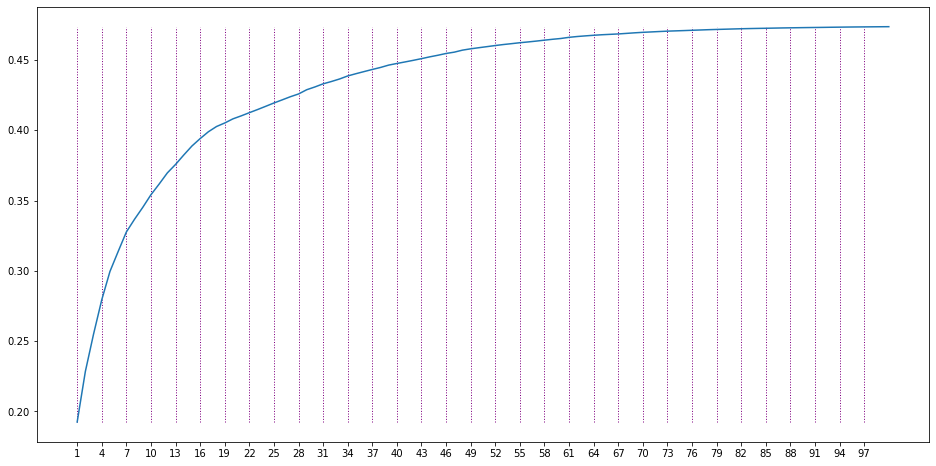

Optimal number of features:  18


('Basic_Demos,Age',
 'SCQ,SCQ_05',
 'SCQ,SCQ_39',
 'Barratt,financialsupport',
 'SDQ,SDQ_20',
 'SWAN,SWAN_06',
 'SRS,SRS_43',
 'CBCL,CBCL_17',
 'APQ_P,APQ_P_18',
 'APQ_P,APQ_P_31',
 'APQ_P,APQ_P_37',
 'ESWAN,MDD_5',
 'APQ_SR,APQ_SR_05',
 'APQ_SR,APQ_SR_38',
 'PSI,PSI_02',
 'PSI,PSI_08',
 'PSI,PSI_18',
 'RBS,RBS_36')

Score using all features: 
WISC,WISC_FSIQ
r2:  0.4446497684142876


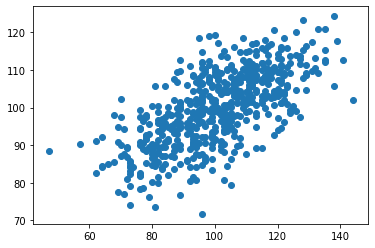

R2:  0.4446497684142876
Performance on test set using optimal number of columns: 
WISC,WISC_FSIQ
r2:  0.3871212320284366


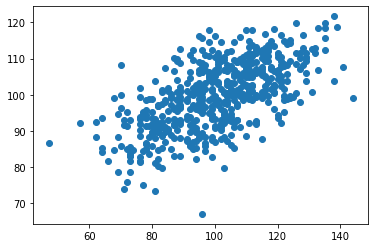

R2:  0.3871212320284366
Performance on test set using number of columns with maximum score
WISC,WISC_FSIQ
r2:  0.4302194539611034


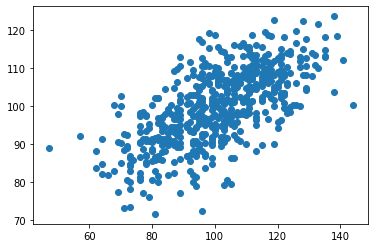

R2:  0.4302194539611034
WISC,WISC_SS_Scaled


,r2
1,0.053645
2,0.067750
3,0.079969
4,0.091022
5,0.106628
...,...
96,0.149738
97,0.152605
98,0.154892
99,0.155849


Max score:  0.15584931744894162  at  99  features


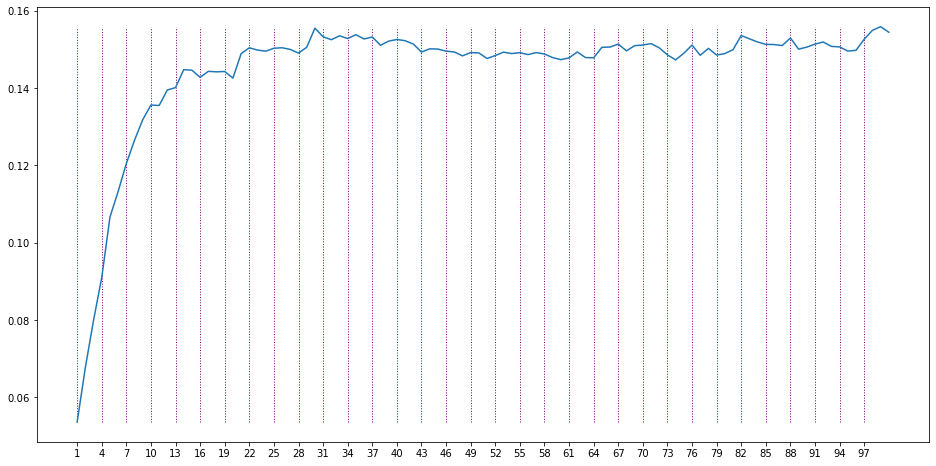

Optimal number of features:  14


('SympChck,CSC_18P',
 'SympChck,CSC_43C',
 'SCQ,SCQ_03',
 'ASSQ,ASSQ_04',
 'ASSQ,ASSQ_11',
 'CBCL,CBCL_03',
 'CBCL,CBCL_32',
 'ICU_P,ICU_P_02',
 'ICU_P,ICU_P_09',
 'APQ_P,APQ_P_31',
 'ESWAN,Panic_B02',
 'PSI,PSI_05',
 'PSI,PSI_18',
 'RBS,RBS_40')

Score using all features: 
WISC,WISC_SS_Scaled
r2:  0.11249751152765475


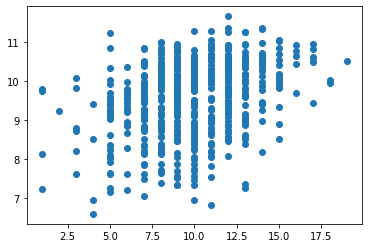

R2:  0.11249751152765475
Performance on test set using optimal number of columns: 
WISC,WISC_SS_Scaled
r2:  0.0538739889167833


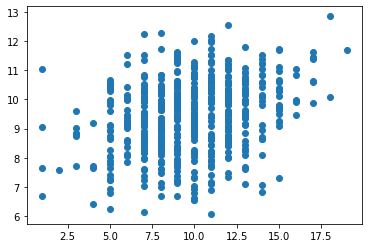

R2:  0.0538739889167833
Performance on test set using number of columns with maximum score
WISC,WISC_SS_Scaled
r2:  0.08724352421965831


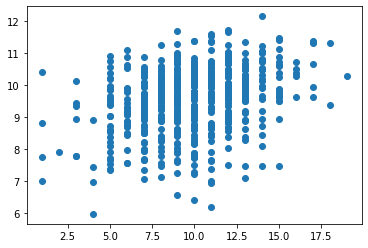

R2:  0.08724352421965831


In [28]:
# Print sfs results
for output in output_cols:
    print(output)
    
    features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects[output].subsets_)
    features_up_to_optimal = list(features_up_to_optimal)
    features_up_to_max_score = list(features_up_to_max_score)
    
    # Test both subsets on test set
    estimator = best_estimators[output]
    
    # All features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[input_cols], train_set[output])
    print("Score using all features: ")
    metrics = get_metrics(new_estimator, output, input_cols, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])
    
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_optimal], train_set[output])
    print("Performance on test set using optimal number of columns: ")
    metrics = get_metrics(new_estimator, output, features_up_to_optimal, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])

    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_max_score], train_set[output])
    print("Performance on test set using number of columns with maximum score")
    metrics = get_metrics(new_estimator, output, features_up_to_max_score, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])